In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from CarDataset import CarDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.ion()    # interactive mode

# Load data and transform

### train dataset transform
- (224 * 224)으로 resize  
- 좌우 반전  
- 정규화 ( mean : [0.454952, 0.460148, 0.470733], std : [0.302969, 0.294664, 0.295581] )  

### test dataset transform
- (256 * 256)으로 resize  
- 정규화 ( mean : [0.454952, 0.460148, 0.470733], std : [0.302969, 0.294664, 0.295581] )  

mean, std 값은 지금 사용하고 있는 dataset에 대해서 구한 mean, std 값 사용  


In [5]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.454952, 0.460148, 0.470733], [0.302969, 0.294664, 0.295581])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.454952, 0.460148, 0.470733], [0.302969, 0.294664, 0.295581])
    ]),
}
train_dataset = CarDataset('data/cars/anno_train.csv', 'data/cars/train/', transform=data_transforms['train'])

train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

val_dataset = CarDataset('data/cars/anno_test.csv', 'data/cars/test/', transform=data_transforms['val'])

val_dataLoader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

dataloaders = {}
dataloaders['train'] = train_dataLoader
dataloaders['val'] = val_dataLoader

#dataset_sizes['train'] = train set 사진 갯수
#dataset_sizes['val'] = val set 사진 갯수
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['val'] = len(val_dataset)

# Batch images visualization

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.454952, 0.460148, 0.470733])
    std = np.array([0.302969, 0.294664, 0.295581])
    inp = std * inp + mean   # 정규화를 해제
    inp = np.clip(inp, 0, 1) # 값들의 범위를 제약 inp는 0과 1사이의 값으로 표현된다.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Model training function

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict()) # model의 매개변수들을 불러온다.
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)
    
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            count = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림
                
                # zero the parameter gradients
                optimizer.zero_grad() #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels) 

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward() #backward
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if count%100 == 0:
                    print(count)
                count+=1
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

# Training

- 사용한 pre-trained model : resNet18  
- 손실 함수 : cross entropy function  
- batch size : 4, learning rate : 0.001, momentum : 0.9  

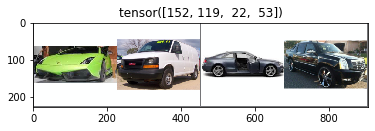

In [8]:
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 4로 했으니 사진 4장이 로드된다.
inputs, classes = next(iter(dataloaders['train']))

# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
out = torchvision.utils.make_grid(inputs)
#--
# 이미지를 출력한다.
imshow(out, str(classes))

model_ft = models.resnet18(pretrained=True) 
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs, 196)  # Pre-trained model의 끝단에 fully-connected layer 추가 class가 196개 이므로 196

model_ft = model_ft.to(device) # cpu로 이동

#------손실함수/optimizer
criterion = nn.CrossEntropyLoss() #loss 함수로 cross entropy

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # optimizer로 SGD사용

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)